# The problem

We're interested in interpolating a sparse 3-dimensional dataset of velocity vectors into a regularly spaced grid. Vectors in the sparse dataset will be interpolated 4 times, corresponding to total magnitude ('v_mag'), velocity in the east direction ('v_x'), velocity in the north direction ('v_y'), and velocity in the vertical direction ('v_z').

We are using a gaussian process regressor to interpolate the data. This is a regression process in which many possible functions of a given kernel are fit to the training data as likelihood functions, and the mean of the fit functions (posterior distribution) is used as the predictor. See the below example of the rational quadratic kernel from scikit-learn's documentation:

![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_prior_posterior_002.png "Rational quadratic regressor")

Several kernels can be viewed [here](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html). Kernel hyperparameters (e.g. length_scale) are optimized during the fit process.

It is possible to load the entirety of the dataset in at once and try to fit a gaussian process regressor. However, gaussian processes scale poorly with the number of training points ~O(n^3). To interpolate a large spatial area, it is necessary to divide the space up into discrete chunks, with some overlap, and individually interpolate and merge data at the end. The size of the chunks becomes a model hyperparameter.

## Module imports

This analysis notebook uses a number of Python modules for analysis installed from anaconda libraries as well as the package adcpkrig (contained within this directory) and the module prototype_utils.py, which contains helper functions to analyze outputs and display the examples in this notebook.

The project repository can be found at [github](https://github.com/TauCritical/adcpkrig) (note:currently private).

In [1]:
import importlib
import adcpkrig
import numpy as np
import sklearn.gaussian_process
import pandas as pd
import matplotlib as mpl
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Custom:

In [2]:
import prototype_utils
from prototype_utils import analysis
from prototype_utils import MAE

In [3]:
importlib.reload(prototype_utils)
importlib.reload(adcpkrig)
importlib.reload(adcpkrig.grid_utils)
importlib.reload(adcpkrig.read_data)
importlib.reload(adcpkrig.make_chunks)
importlib.reload(numpy)

<module 'numpy' from 'C:\\Users\\eab4\\MyApps\\Anaconda\\envs\\Krig3d\\lib\\site-packages\\numpy\\__init__.py'>

## Read data

In [4]:
pd.read_csv('vpts_sample.csv').head()

,FID,ens_ID,origEnsID,profile,lat,lon,date,num_bins,avg_depth,v_avg,...,roll,corr_head,magVar000,magVar001,gpsVelMag,gpsVelAz,vRfrnc,good,POINT_X,POINT_Y
0,0,2,20,20190618_0_117_ASC.TXT,39.202385,-93.782630,2019:6:18:17:57.6:8,6,4.895000,0.613267,...,0.27,254.78,nodata,nodata,0.527928,255.890054,GGA,1,432423.721191,4.339528e+06
1,1,3,21,20190618_0_117_ASC.TXT,39.202383,-93.782636,2019:6:18:17:57.7:10,6,4.860000,0.743650,...,0.26,248.64,nodata,nodata,0.521070,252.083158,GGA,1,432423.224175,4.339527e+06
2,2,4,22,20190618_0_117_ASC.TXT,39.202381,-93.782642,2019:6:18:17:57.8:13,6,4.806667,0.929033,...,0.12,243.22,nodata,nodata,0.598599,242.424682,GGA,1,432422.691624,4.339527e+06
3,3,5,23,20190618_0_117_ASC.TXT,39.202378,-93.782649,2019:6:18:17:57.9:15,6,4.875000,0.676133,...,0.38,237.55,nodata,nodata,0.653087,237.417112,GGA,1,432422.138561,4.339527e+06
4,4,6,24,20190618_0_117_ASC.TXT,39.202373,-93.782655,2019:6:18:17:57.10:18,6,4.852500,0.810483,...,0.26,231.30,nodata,nodata,0.732683,227.837829,GGA,1,432421.591198,4.339526e+06


In [5]:
pd.read_csv('bin_sample.csv').head()

,ens_ID,bin,depth,v_mag,v_emag,v_nmag,v_hdir,v_vcomp,v_error
0,2,1,1.08,0.2451,0.143,-0.199,144.43,0.076,0.042
1,2,2,1.58,0.6016,0.597,0.072,83.17,-0.021,0.004
2,2,3,2.08,0.4310,0.284,0.324,41.23,-0.043,-0.067
3,2,4,2.58,0.6498,0.542,0.358,56.55,0.016,0.050
4,2,5,3.08,0.8183,0.793,0.203,75.60,-0.005,0.393


In [6]:
df = adcpkrig.createdf('vpts_sample.csv','bin_sample.csv')

In [7]:
df.head()

,X,Y,Z,v_mag,v_x,v_y,v_z
0,432423.721191,4.339528e+06,-1.08,0.2451,0.143,-0.199,0.076
1,432423.721191,4.339528e+06,-1.58,0.6016,0.597,0.072,-0.021
2,432423.721191,4.339528e+06,-2.08,0.4310,0.284,0.324,-0.043
3,432423.721191,4.339528e+06,-2.58,0.6498,0.542,0.358,0.016
4,432423.721191,4.339528e+06,-3.08,0.8183,0.793,0.203,-0.005


In [8]:
np.random.seed(8)

rand = np.random.rand(len(df))
train = rand < 0.8 
val = (rand >= 0.8 ) & (rand < 0.9)
test = rand >= 0.9

traindf = df[train]
valdf = df[val]
testdf = df[test]

In [9]:
anal1 = analysis(traindf,valdf,(10,4,20,4))
anal1.load_data(2)
anal1.mergepredicts()

## One chunk only

This section shows one chunk of analysis only

In [10]:
predict1,sigma,test = anal1.interponechunk(883,'v_mag') #default kernel = rational quadratic
kernel2 = sklearn.gaussian_process.kernels.RBF()
predict2,sigma,test = anal1.interponechunk(883,'v_mag',kernelparams=kernel2)

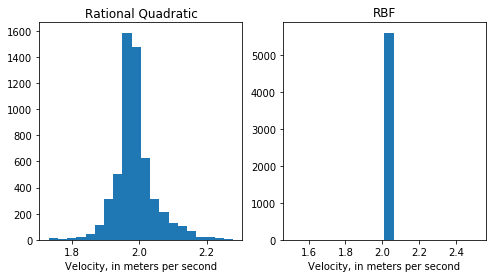

In [11]:
anal1.compare1(predict1,predict2,title1='Rational Quadratic',title2='RBF')

In [12]:
predict1,sigma,test = anal1.interponechunk(883,'v_mag')
kernel2 = sklearn.gaussian_process.kernels.Matern()
predict2,sigma,test = anal1.interponechunk(883,'v_mag',kernelparams=kernel2)

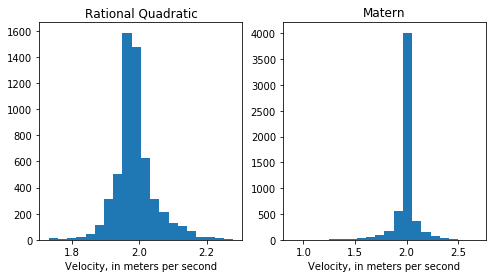

In [13]:
anal1.compare1(predict1,predict2,title1='Rational Quadratic',title2='Matern')

Text(0, 0.5, 'Interpolated')

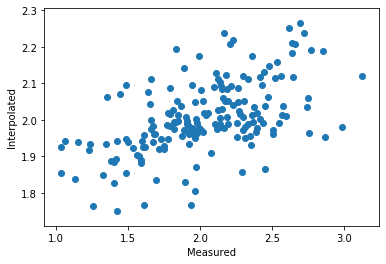

In [27]:
comparedf = anal1.accuracycompareonechunk(883,predict1,'v_mag')

plt.scatter(comparedf.v_mag,comparedf.v)
ax = plt.gca()
ax.set_xlabel('Measured')
ax.set_ylabel('Interpolated')

In [15]:
MAE(comparedf.v_mag,comparedf.v)

0.299908624724627

## Comparing interpolation to general shape of measurements

Below we compare the interpolated grid to measurements within the chunk used to fit the model 

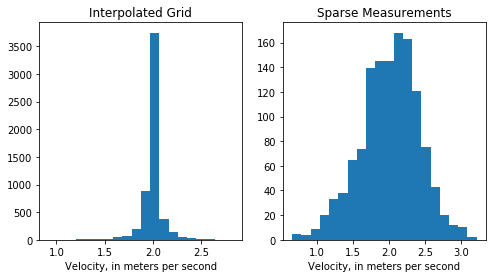

In [16]:
anal1.compare1(anal1.predicts_mag[883],anal1.readrawonechunk(883,'v_mag'))

True

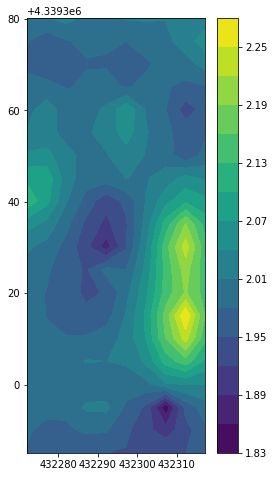

In [35]:
anal1.showchunk(884,predict1,-3.08)

Here's an example of why it's important to have a reproducible scientific computing environment. The below is the same code run on two different versions of sklearn. The results are different. Here we'll take a side diatribe on docker/environments/aws.

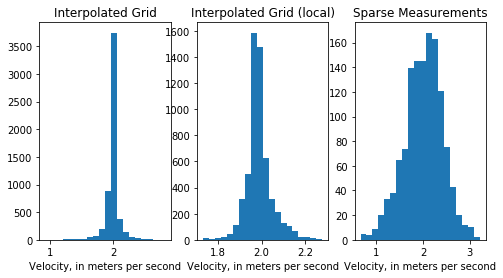

In [18]:
predict1,sigma,test = anal1.interponechunk(883,'v_mag')
anal1.compare2(anal1.predicts_mag[883],predict1,anal1.readrawonechunk(883,'v_mag'))

The code iterates over all chunks, fits, and merges based on grid cell mean. Below shows a map as well as cell size to give an impression of size/overlap.

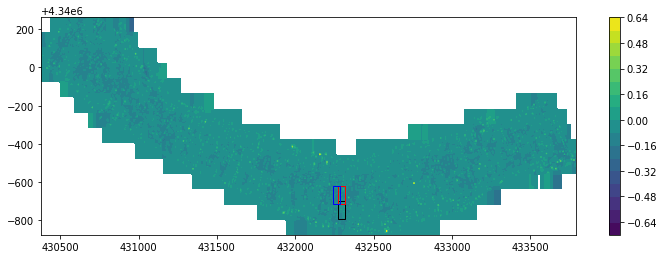

In [41]:
anal1.showmap(-3.08,chunknum=883,chunknum2=884,chunknum3=870,vdir='v_z')

Here's a histogram of all grid cells in the interpolated data

(0, 3.5)

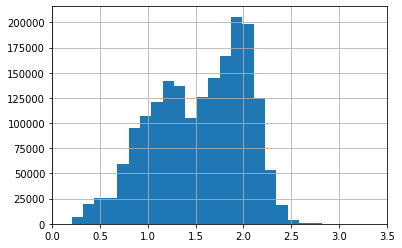

In [20]:
ax = anal1.alldf.v_mag.hist(bins=50)
ax.set_xlim(0,3.5)

(0, 3.5)

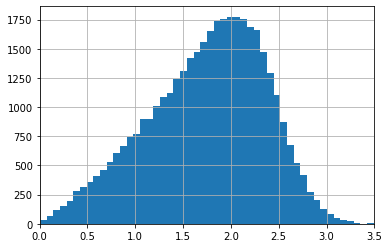

In [21]:
ax = anal1.comparedf.v_mag.hist(bins=50)
ax.set_xlim(0,3.5)

In [22]:
anal1.calcaccuracy()

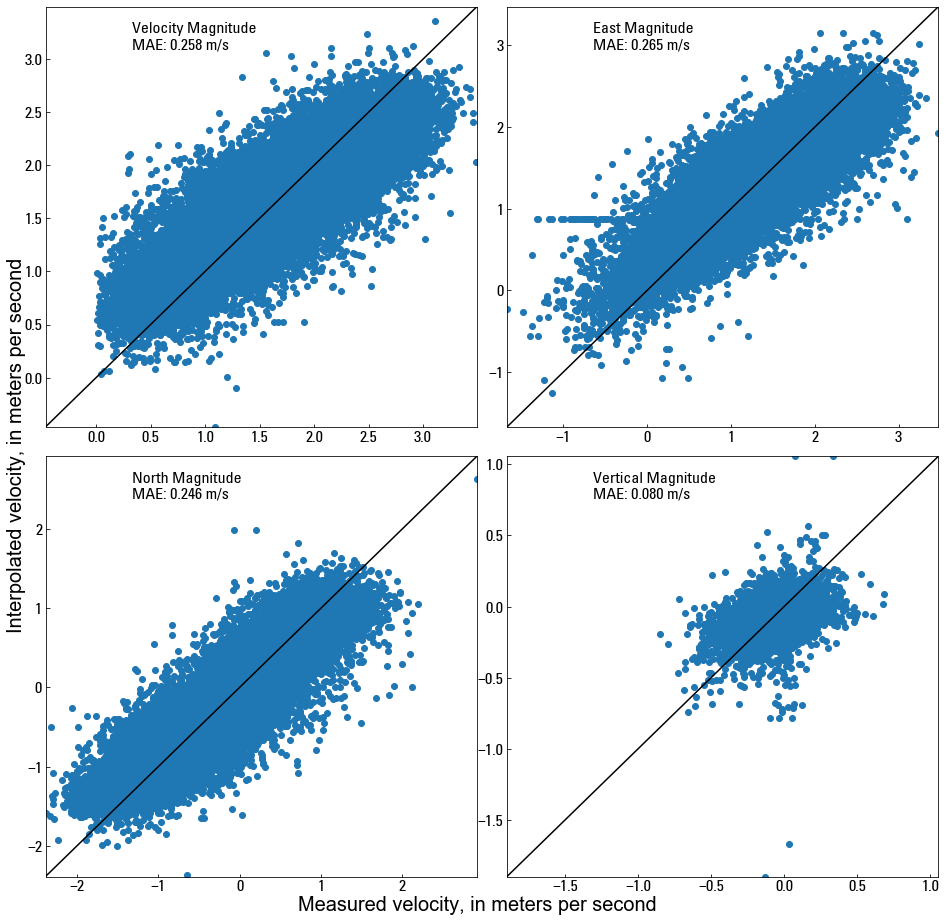

In [23]:
anal1.plotscatter()

In [24]:
runs = pd.read_csv('batch numbers.csv',index_col=0)
runs

,Large Dim,Large Overlap,Small Dim,Small Overlap,Kernel,Environment
Run Number,,,,,,
1,10,4,10,4,default,0.19.0
2,10,4,20,4,default,0.19.0
3,10,4,40,4,default,0.19.0
4,20,4,10,4,default,0.19.0
5,20,4,20,4,default,0.19.0
6,20,4,40,4,default,0.22.1
7,40,4,10,4,default,0.22.1
8,40,4,20,4,default,0.22.1
9,40,4,40,4,default,0.22.1


1
2
3
4
5
6


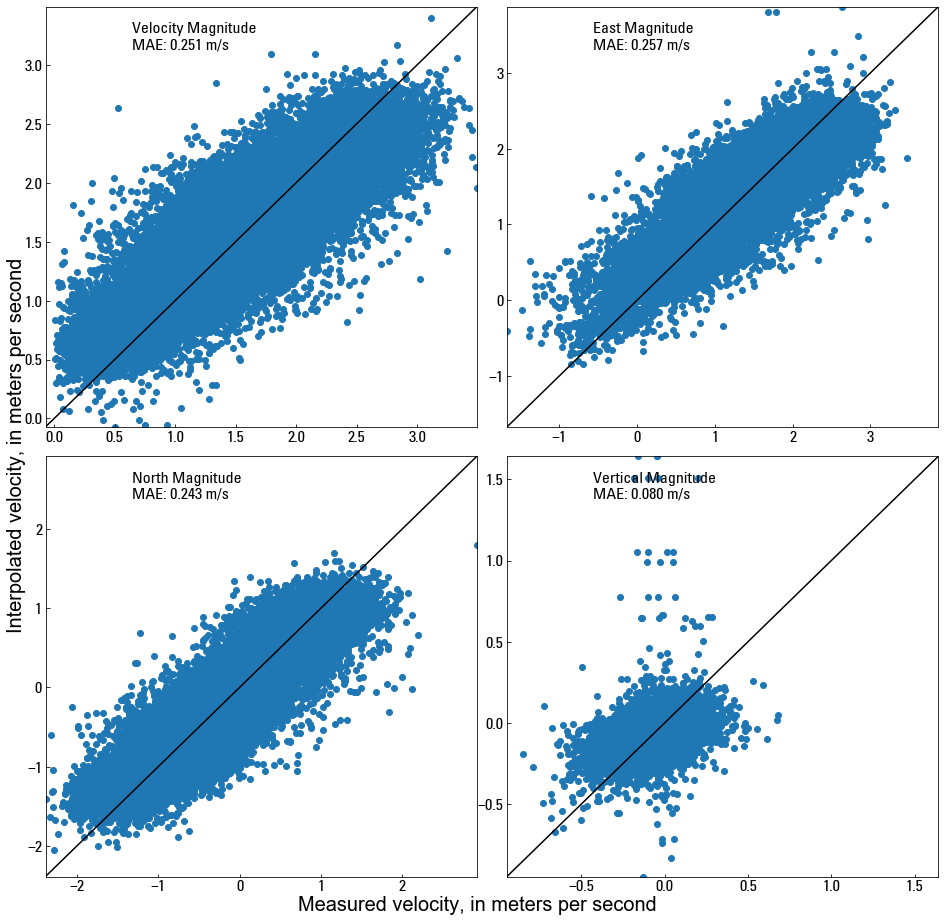

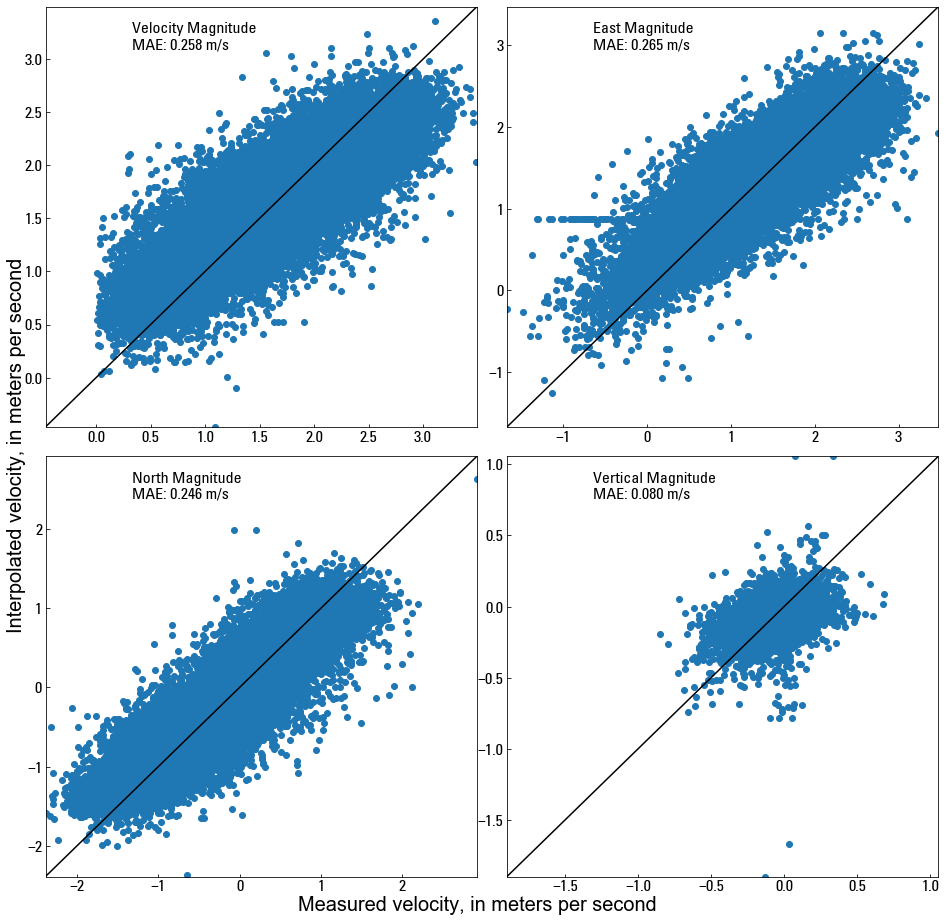

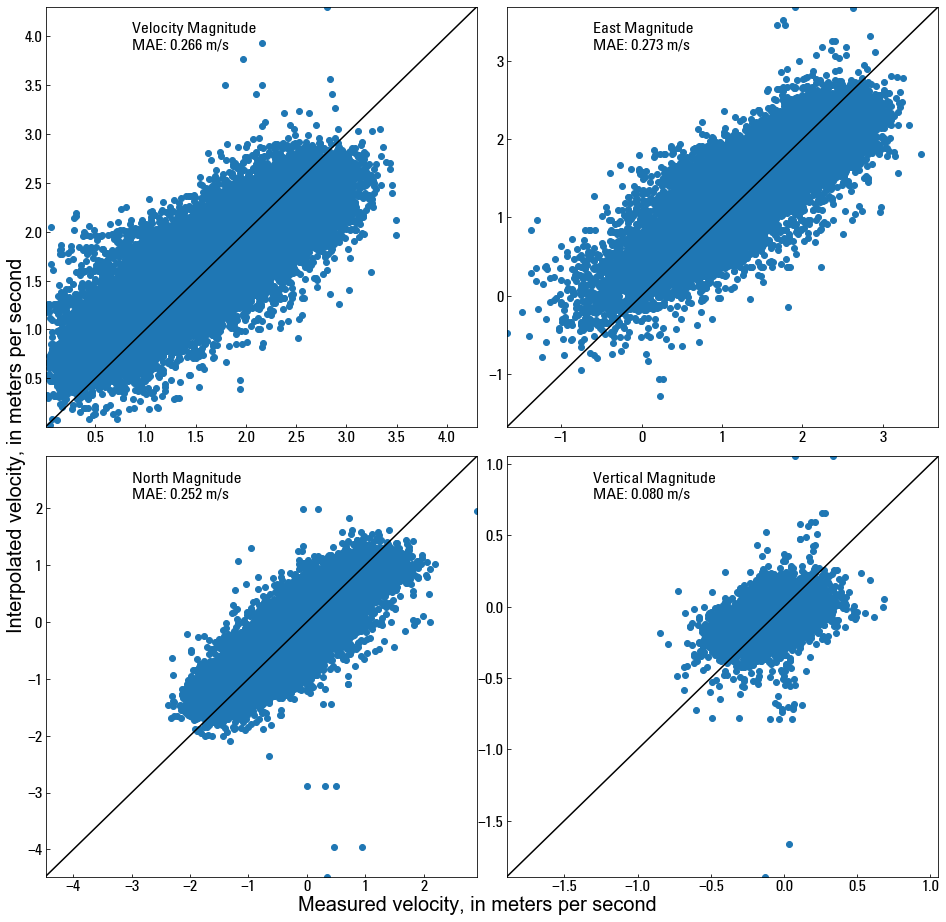

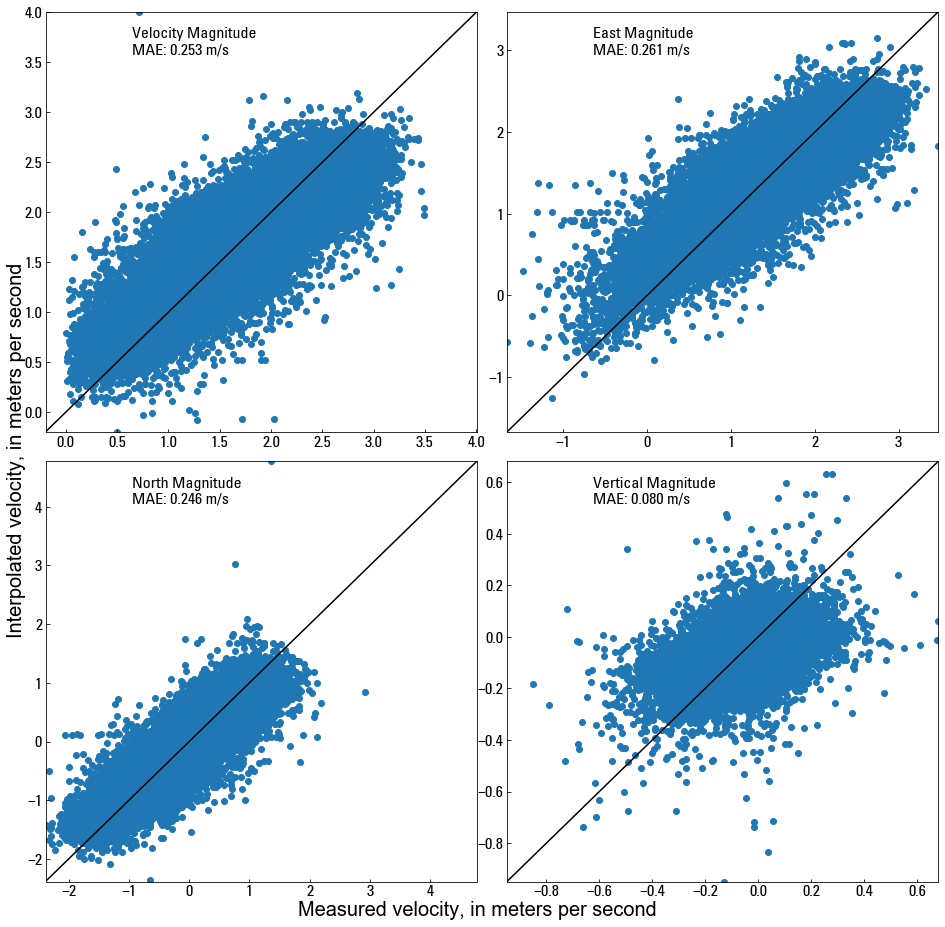

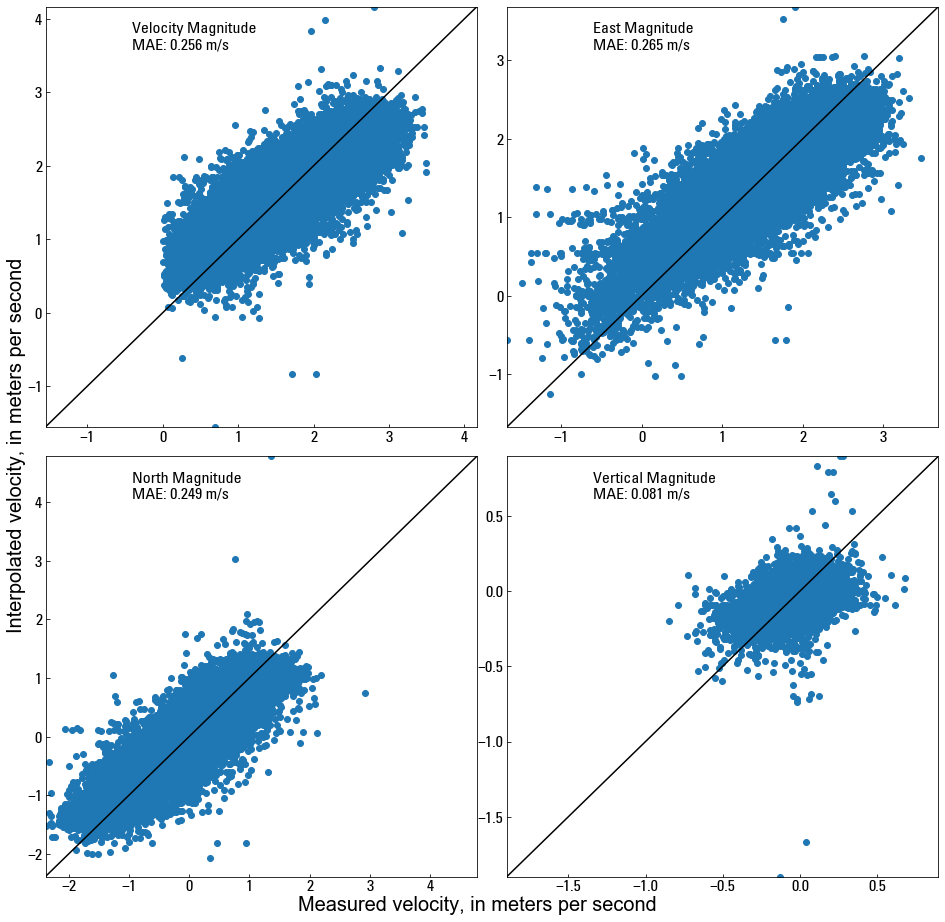

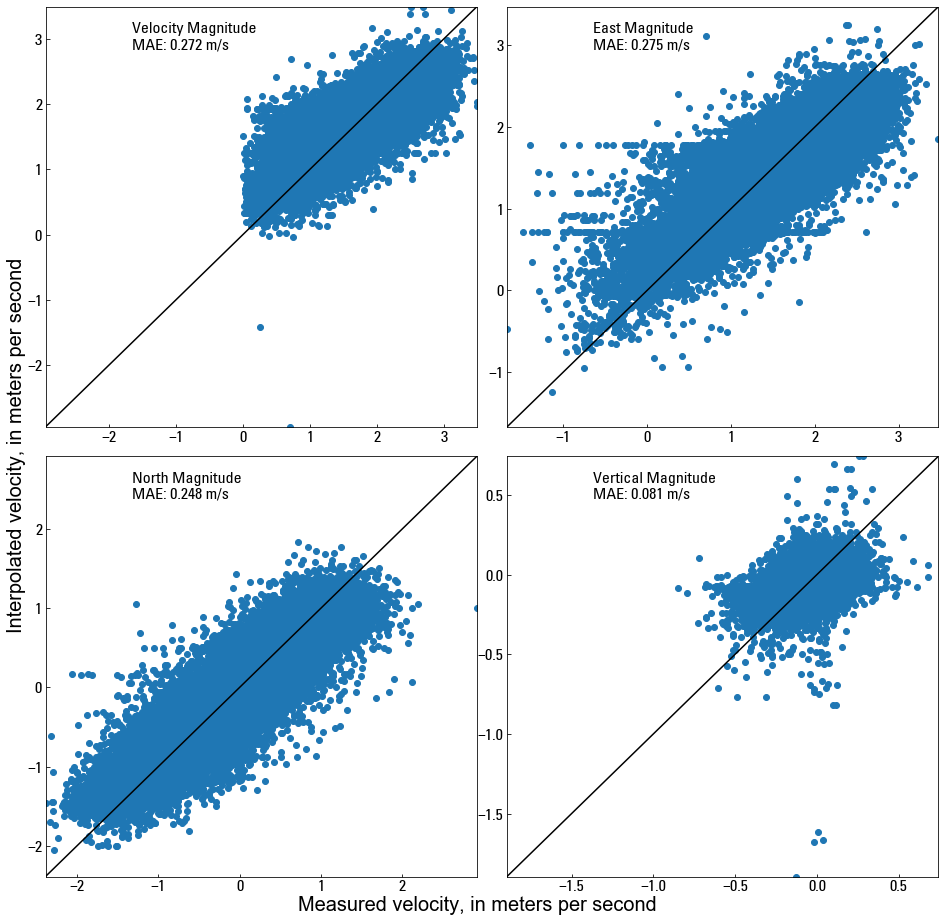

In [25]:
analyses = {}

for i in range(1,7):
    print(i)
    largedim = runs['Large Dim'][i]
    largeoverlap = runs['Large Overlap'][i]
    smalldim = runs['Small Dim'][i]
    smalloverlap = runs['Small Overlap'][i]
    analyses[i] = analysis(traindf,valdf,(largedim,largeoverlap,smalldim,smalloverlap))
    analyses[i].load_data(i)
    analyses[i].mergepredicts()
    analyses[i].calcaccuracy()
    analyses[i].plotscatter()